# Датасет ирисы Фишера
## Подготовка датасета


Импортируем датасет с ирисами из *skrlearn.datasets*. Столбцы *sl*, *sw*, *pl*, *pw* - это некоторые параметры различных ирисов, а *target* - это тип ириса.

In [1]:
from sklearn.datasets import load_iris
import numpy  as np
import pandas as pd

iris = load_iris()
iris_pd=pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])
iris_pd = iris_pd.rename(columns={'sepal length (cm)': 'sl', 'sepal width (cm)': 'sw', 'petal length (cm)': 'pl', 'petal width (cm)': 'pw'})

print(iris_pd)
print(iris_pd.describe())

      sl   sw   pl   pw  target
0    5.1  3.5  1.4  0.2     0.0
1    4.9  3.0  1.4  0.2     0.0
2    4.7  3.2  1.3  0.2     0.0
3    4.6  3.1  1.5  0.2     0.0
4    5.0  3.6  1.4  0.2     0.0
..   ...  ...  ...  ...     ...
145  6.7  3.0  5.2  2.3     2.0
146  6.3  2.5  5.0  1.9     2.0
147  6.5  3.0  5.2  2.0     2.0
148  6.2  3.4  5.4  2.3     2.0
149  5.9  3.0  5.1  1.8     2.0

[150 rows x 5 columns]
               sl          sw          pl          pw      target
count  150.000000  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.057333    3.758000    1.199333    1.000000
std      0.828066    0.435866    1.765298    0.762238    0.819232
min      4.300000    2.000000    1.000000    0.100000    0.000000
25%      5.100000    2.800000    1.600000    0.300000    0.000000
50%      5.800000    3.000000    4.350000    1.300000    1.000000
75%      6.400000    3.300000    5.100000    1.800000    2.000000
max      7.900000    4.400000    6.900000    2.500000    2.00000

## 1. Разведочный анализ данных

### Построить диаграмму Тьюки, оценить диапазон изменения данных.

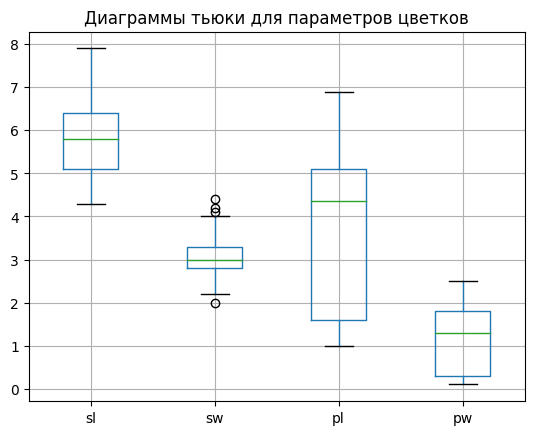

In [2]:
import matplotlib.pyplot as plt

iris_pd.iloc[:,:-1].boxplot()
plt.title('Диаграммы тьюки для параметров цветков')
plt.show()

Значения всех переменных сравнимы по величине, но находятся в нескольких разных диапазонах и имеют разный разброс. Также стоит отметить, что для значений sw имеем большое количество выбросов.

### Проанализировать корреляционные зависимости между исследуемыми переменными. Необходимо построить тепловую карту.

Парная корреляция между i и j переменными можно найти по следующей формуле: 
$$ \hat{r}_{ik} = \frac{ \hat{ \sigma}_{ik} }{\hat{\sigma}_{ii}\hat{\sigma}_{kk}} $$

              sl        sw        pl        pw    target
sl      1.000000 -0.117570  0.871754  0.817941  0.782561
sw     -0.117570  1.000000 -0.428440 -0.366126 -0.426658
pl      0.871754 -0.428440  1.000000  0.962865  0.949035
pw      0.817941 -0.366126  0.962865  1.000000  0.956547
target  0.782561 -0.426658  0.949035  0.956547  1.000000


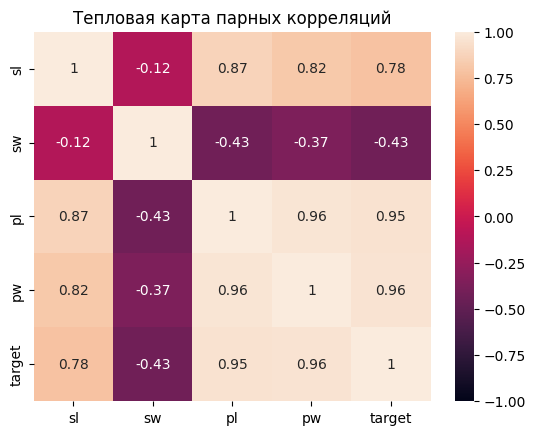

In [3]:
import seaborn as sns

corr_matr = iris_pd.corr()
print(corr_matr)

sns.heatmap(corr_matr, annot= True, vmin=-1, vmax=1)
plt.title('Тепловая карта парных корреляций')
plt.show()

Практически все переменные имеют высокие линейные связи друг с другом, кроме пар содержащих sw. Еще можно обратить внимание, что парные корреляции отдельных переменных со всеми остальными имеют похожие значения.

### Рассчитать частные коэффициенты корреляции, сравнить их со значениями парных коэффициентов корреляции. Необходимо построить тепловую карту.

Частная корреляция между i и j переменными можно найти по следующей формуле: 
$$ \hat{r}_{ik|1,\dots,L} = - \frac{\hat{R}_{ik}}{\sqrt{\hat{R}_{ii}\hat{R}_{kk}}}, \text{где }\hat{R}_{xy}\text{ -- алгебраическое дополнение корреляционной матрицы}  $$

              sl        sw        pl        pw    target
sl      1.000000  0.610735  0.723756 -0.220409 -0.159156
sw      0.610735  1.000000 -0.565057  0.336649 -0.055676
pl      0.723756 -0.565057  1.000000  0.578470  0.316796
pw     -0.220409  0.336649  0.578470  1.000000  0.472174
target -0.159156 -0.055676  0.316796  0.472174  1.000000


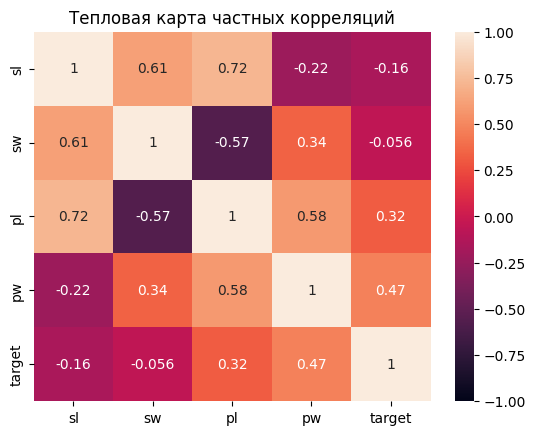

In [4]:
import pingouin

pcorr_matr = iris_pd.pcorr()
print(pcorr_matr)

sns.heatmap(pcorr_matr, annot= True, vmin=-1, vmax=1)
plt.title('Тепловая карта частных корреляций')
plt.show()

По сравнению с матрицей парных корреляций частные корреляции отдельных переменных со всеми остальными значительно различаются, в том числе могут менять знак. Можно отметить, что тип цветка, судя по значениям коэффициентов частной корреляции, в большей мере определяется параметрами *pl* и *pw*.

Расчитаем коэффициент множественной корреляции для target. Это можно сделать по следующей формуле:
$$\hat{R}_{y|x^{(1)}\dots x^{(M-1)}} = \sqrt{1 - \frac{|\hat{R}|}{\hat{R}_{ii}}} $$

In [14]:
#Количество параметров
n = len(iris_pd)
k = len(iris_pd.iloc[0]) - 1

def minor(A, i, j):
    a_shape = A.shape[0]
    M = np.eye(a_shape - 1)
    M[:i,:j] = A[:i,:j]
    M[:i,j:] = A[:i,j+1:]
    M[i:,:j] = A[i+1:,:j]
    M[i:,j:] = A[i+1:,j+1:]

    return M

def alg_dop(A, i, j):
    M = minor(A, i, j)
    return (-1)**(i+j) * np.linalg.det(M)

R = corr_matr.values
#Множественная корреляция y к x-ам
R_y_x = np.sqrt(1 - np.linalg.det(R)/alg_dop(R, k-1, k-1))
print(f'Коэффициент множественной корреляции {pred_column}: {R_y_x:.3f}')

Коэффициент множественной корреляции pw: 0.976


По большому значению коэффициента множественной корреляции, можно сказать, что *pw* имеет сильную линейную связь с его параметрами.

### Проверить предположение о распределении признаков по нормальному закону критерием Колмогорова-Смирнова. Необходимо рассчитать значения статистик.

In [6]:
import scipy.stats

kstest_res = [ scipy.stats.kstest(iris_pd.iloc[:,i], 'norm') for i in range(len(iris_pd.iloc[0]))]
for i in range(len(kstest_res)):
    print(f'Значение статистики для {iris_pd.columns[i]}: {kstest_res[i].statistic:.3f}, pvalue: {kstest_res[i].pvalue:.2e}')

Значение статистики для sl: 1.000, pvalue: 0.00e+00
Значение статистики для sw: 0.979, pvalue: 1.93e-253
Значение статистики для pl: 0.877, pvalue: 1.40e-136
Значение статистики для pw: 0.546, pvalue: 1.88e-42
Значение статистики для target: 0.508, pvalue: 2.10e-36


По результатам критерия Колмогорова-Смирнова данные столбцы противоречат предположению о нормальности закона распределения данных величин, поскольку значение pvalue в каждой из них практически нулевое.

### Сделать выводы о степени однородности данных, силе зависимости между переменными, виде функции распределения, наиболее информативных переменных.

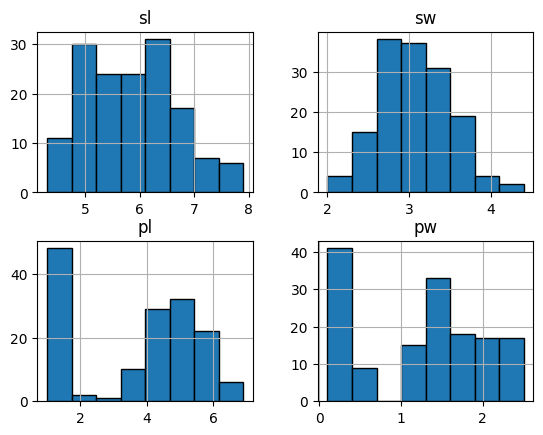

In [7]:
iris_pd.iloc[:,:-1].hist(bins = 8, edgecolor='black')
plt.show()

Построим гистограммы имеющихся данных. По ним видно, что оценки законов распределения данных выборок весьма различны и отличаются от нормального закона распределения, что подтвердил критерий Колмогорова-Смирнова. Заметим, что характер оценок дифференциального закона распределения для *pl* и *pw* визуально похож.

Судя по корреляционным коэффициентам, параметры ирисов имеют, как минимум, небольшую линейную связь. Есть связи как прямые так и обратные и их силы различны. 

## Построение регрессии

### Определить входные и выходные переменные. Построить парную регрессию и множественную регрессию (Используем sklearn).

При построении парной линейной регрессии мы рассматриваем модель вида: $ \hat{y} = \hat{b}_0 + \hat{b}_1\cdot x $, где коэффициенты $\hat{b}_0,\,\hat{b}_1$ - это неизвестные, которые находятся по выборке.
Модель множественной линейной регрессии имеет вид: $ \hat{y} = \hat{b}_0 + \widehat{\vec{b}^T}\vec{x} $

Для оценки качества модели будем использовать коэффициенты детерминации и скорректированной детерминации:
$$ R^2 = 1 - \frac{Q_{\text{ост}}}{Q_{\text{общ}}},\;R^2_\text{корр} = 1 - \frac{S^2_\text{ост}}{S^2_\text{общ}} $$
$$ \text{Здесь } Q_\text{общ} = \sum\limits_{j=1}^N (y_j - \bar{y_j})^2,\;Q_\text{ост} = \sum\limits_{j=1}^N (\hat{y}_j - y_j)^2,\; S^2_\text{общ} = \frac{Q_\text{общ}}{N-1},\;S^2_\text{ост} = \frac{Q_\text{ост}}{N-k} $$

Пусть в качестве выходной переменной будет выступать *pw*, а входными будут остальные параметры.

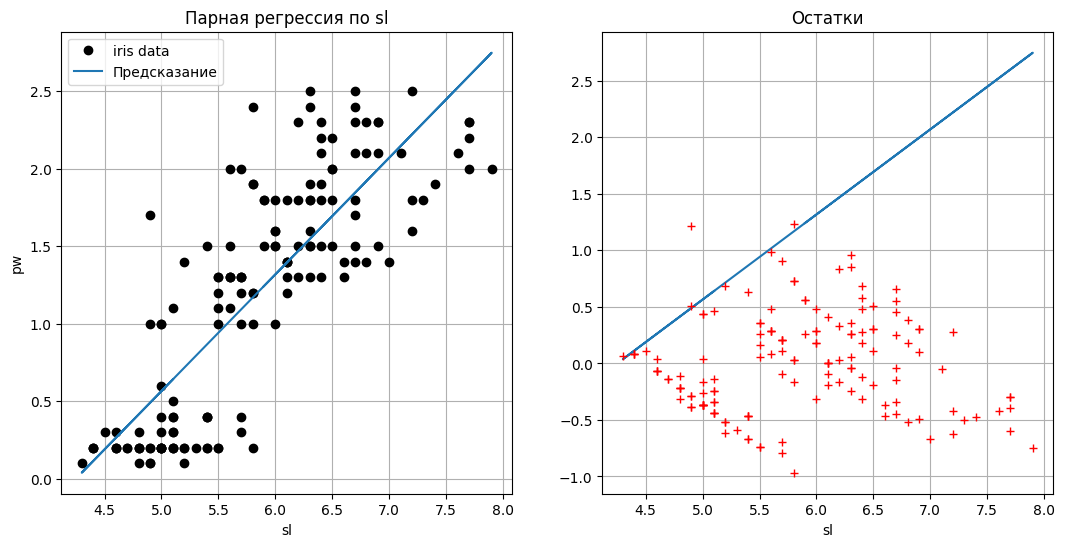

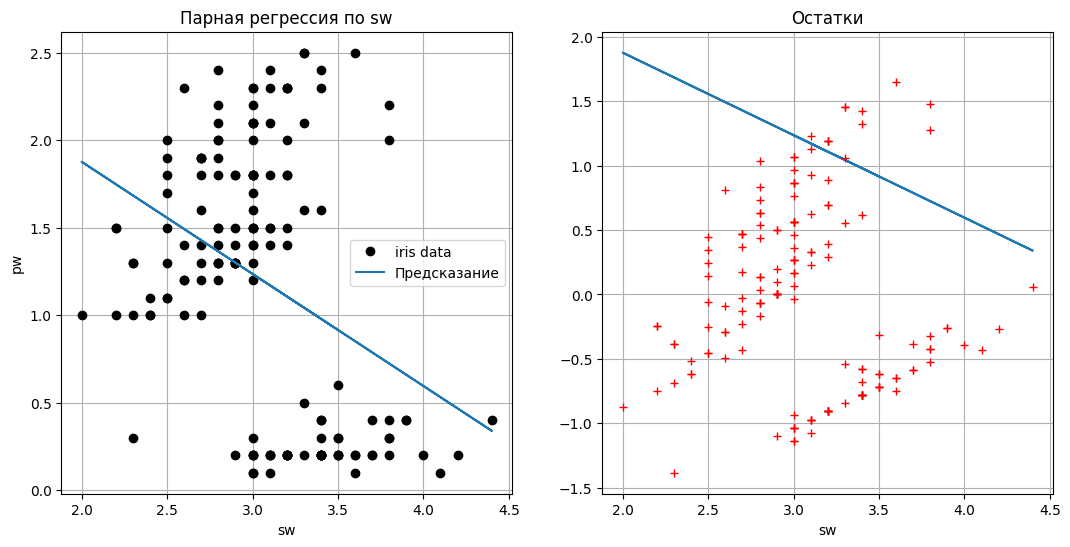

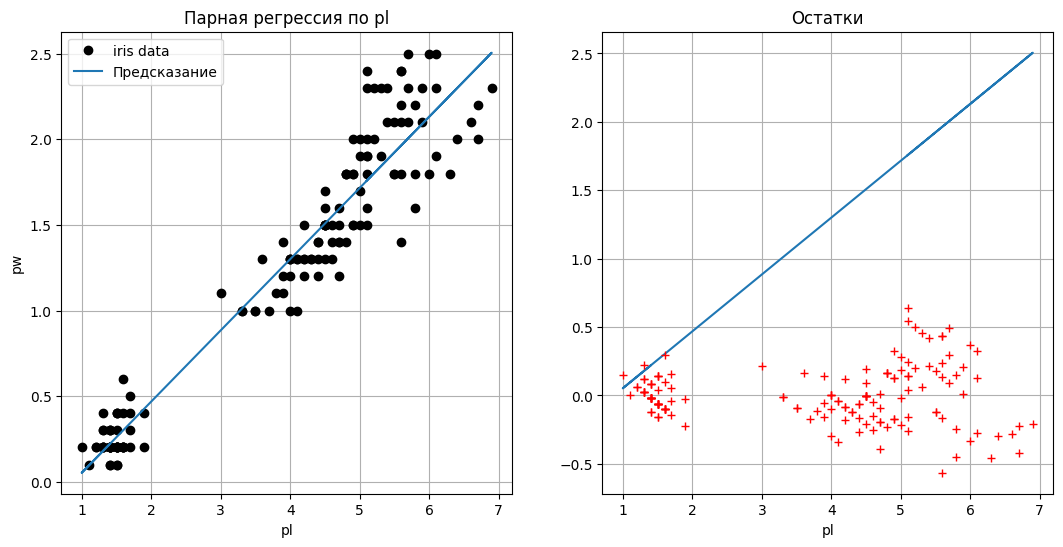

Коэффициенты детерминации
sl: 0.669	sw: 0.134	pl: 0.927	
Коэффициенты скорректированной детерминации
sl: 0.669	sw: 0.134	pl: 0.927	
Стандартная ошибка
sl: 0.437	sw: 0.707	pl: 0.205	
Q общее: 86.570
Q остаточное
sl: 28.652	sw: 74.965	pl: 6.310	


In [8]:
from sklearn import linear_model
#Получение парной линейной регресси
def pair_regress(data_pd, x_name, y_name):
    x = data_pd[x_name].values.reshape(-1, 1)
    y = data_pd[y_name].values.reshape(-1, 1)

    reg = linear_model.LinearRegression()
    reg.fit(x,y)

    return reg

#Построить графики результатов регрессии
def plot_regr_results(x, y, y_pred, ylab):
    residues = y - y_pred
    plt.figure(figsize=(12.8,6))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(x, y, 'ko', label='iris data')
    plt.plot(x, y_pred, label='Предсказание')
    plt.title(f'Парная регрессия по {column}')
    plt.xlabel(column)
    plt.ylabel(ylab)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(x, y_pred, label='Предсказание')
    plt.plot(x, residues, 'r+', label='Остатки')
    plt.title('Остатки')
    plt.xlabel(column)
    plt.show()

#Получение коэффициентов детерминации и скорретированной детерминации
def calc_r_squared(y, y_pred, k, return_Q = False):
    res = []
    n = len(y)
    delta_y = (y - y.mean()).reshape(-1)
    residues = (y - y_pred).reshape(-1)
    Q = np.dot(delta_y, delta_y)
    S = Q / (n-1)
    Q_res = np.dot(residues, residues)
    S_res = Q_res / (n-k)
    res.append(1 - Q_res/Q)
    res.append(1 - S_res/S)
    if return_Q:
        res.append(Q)
        res.append(Q_res)

    return res

pred_column = 'pw'

reg = dict()
for column in list(iris_pd.columns)[:-1]:
    if column != pred_column:
        reg[column] = pair_regress(iris_pd, column, pred_column)

R_squared = dict()
R_adj_squared = dict()
Q = None 
Q_res = dict()
RMSE = dict()
iris_y = iris_pd[pred_column].values.reshape(-1, 1)
delta_y = (iris_y - iris_y.mean()).reshape(-1)
for column in reg:
    iris_x = iris_pd[column].values.reshape(-1, 1)
    iris_y_pred = reg[column].predict(iris_x)
    plot_regr_results(iris_x, iris_y, iris_y_pred, pred_column)

    R_sq, R_adj_sq, Q, Q_res[column] = calc_r_squared(iris_y, iris_y_pred, 1, return_Q=True)
    R_squared[column] = (R_sq)
    R_adj_squared[column] = (R_adj_sq)
    RMSE[column] = np.sqrt(((iris_y - iris_y_pred) ** 2).mean())

def print_num_dict(dic, round_to):
    for column, val in dic.items():
        print(f'{column}: {val:.{round_to}f}', end='\t')
    print()

print('Коэффициенты детерминации')
print_num_dict(R_squared, 3)
print('Коэффициенты скорректированной детерминации')
print_num_dict(R_adj_squared, 3)
print('Стандартная ошибка')
print_num_dict(RMSE, 3)
print(f'Q общее: {Q:.3f}')
print(f'Q остаточное')
print_num_dict(Q_res, 3)

Визуально полученные модели парных линейных регрессий подходят к данным и неплохо их оценивают. Модель построенная по второму параметру (*sw*) получилась некачественной, что видно и визуально, и по модулям значений остатков.

Смотря на коэффициенты детерминации, можно сказать, что модели построенные на первых двух параметрах хуже, чем модели на последних двух. В частности, вторая модель вовсе не пригодна, первая не очень хорошая, а последние две можно считать удачными.

Теперь построим модель множественной линейной регрессии.

In [9]:
m_reg = linear_model.LinearRegression()
iris_m_x = iris_pd.iloc[:,:-2].values.reshape(-1, k-1)
iris_m_y = iris_pd[pred_column].values.reshape(-1, 1)
m_reg.fit(iris_m_x, iris_m_y)
reg['multiple'] = m_reg
iris_m_y_pred = m_reg.predict(iris_m_x)
m_residues = (iris_m_y - iris_m_y_pred).reshape(-1)
Q_res['multiple'] = np.dot(m_residues, m_residues)

m_R_squared, m_R_adj_squared = calc_r_squared(iris_m_y, iris_m_y_pred, k-1)
m_RMSE = np.sqrt(((iris_m_y - iris_m_y_pred) ** 2).mean())

print(f'Детерминация: {m_R_squared:.3f}\nСкорректированная детерминация: {m_R_adj_squared:.3f}')
print(f'Стандартная ошибка: {m_RMSE:.3f}')

Детерминация: 0.938
Скорректированная детерминация: 0.937
Стандартная ошибка: 0.189


Для модели множественной линейной регрессии получилось весьма большое значение скорректированного коэффициента детерминации. Оно больше, чем соответствующий коэффициент для любой из построенных ранее парных регрессий, поэтому можно предполагать, что данная модель лучше их.

###  Сравнить результаты парной и множественной регрессии. 

Коэффициенты детерминации
sl: 0.669	sw: 0.134	pl: 0.927	
Коэффициенты скорректированной детерминации
sl: 0.669	sw: 0.134	pl: 0.927	
Стандартная ошибка
sl: 0.437	sw: 0.707	pl: 0.205	
Q общее: 86.570
Q остаточное
sl: 28.652	sw: 74.965	pl: 6.310


|                         | Детерминация | Скорректированная детерминация | Стандартная ошибка |
|-------------------------|--------------|--------------------------------|--------------------|
| Парная регрессия sl     | 0.669        | 0.669                          | 0.437              |
| Парная регрессия sw     | 0.134        | 0.134                          | 0.707              |
| Парная регрессия pl     | 0.927        | 0.927                          | 0.205              |
| Множественная регрессия | 0.938        | 0.937                          | 0.189              |

Исходя из скорректированного коэфициента детерминации, можно считать адекватными последние 3 модели. Самая большая детерминация у модели, построенной на множественной линейной регрессии, поэтому можно считать, что она является наиболее адекватной.

## 3. Проверить гипотезу о нормальном распределении остатков. Рассчитать статистику Дурбина-Уотсона

Проверим гипотезу о нормальности распределения остатков с помощью критерия Колмогорова-Смирнова. Также построим QQ графики для наглядности.

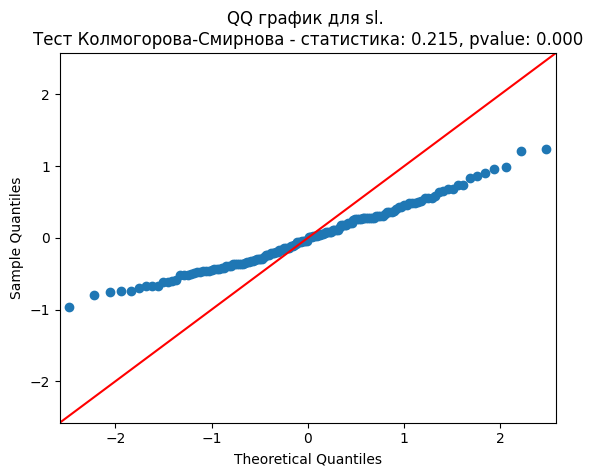

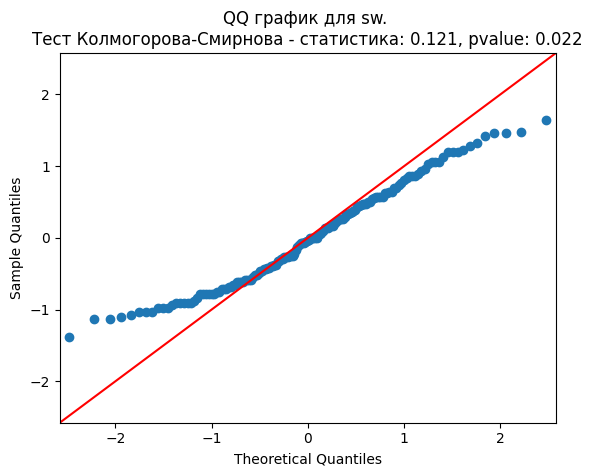

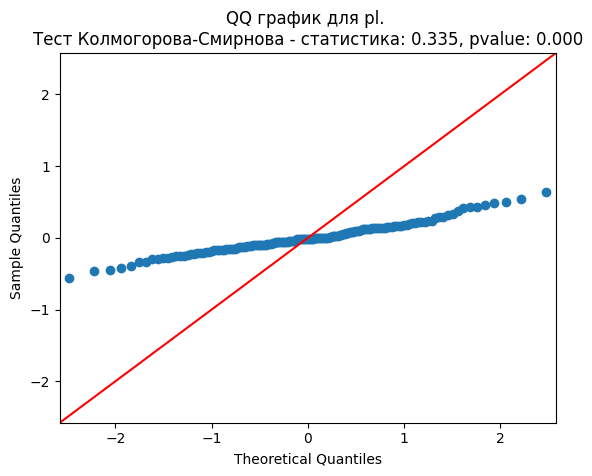

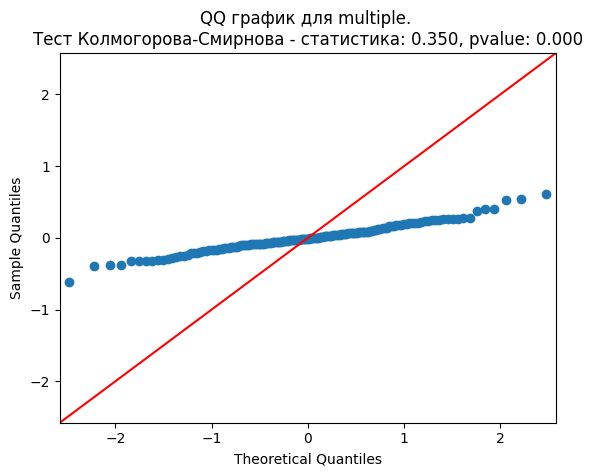

In [10]:
import statsmodels.api as sm

pred = dict()
for column in iris_pd.columns[:-1]:
    if column != pred_column:
        pred[column] = reg[column].predict(iris_pd[column].values.reshape(-1, 1)) 

pred['multiple'] = reg['multiple'].predict(iris_m_x)

residues = dict()
for column in pred.keys():
    y_pred = pred[column]
    residues[column] = (iris_y - y_pred).reshape(-1)

    sm.qqplot(residues[column], line='45')
    ks_res = scipy.stats.kstest(residues[column], 'norm')
    plt.title(f'QQ график для {column}. \nТест Колмогорова-Смирнова - статистика: {ks_res.statistic:.3f}, pvalue: {ks_res.pvalue:.3f}')
    plt.show()

Проверим гипотезу об отсутствии автокорреляции помехи $\varepsilon$ по критерию Дарбина-Уотсона. В нём качестве статистики используется:
$$ \gamma = \frac{\sum\limits_{i=2}^N (\varepsilon_i - \varepsilon_{i-1})}{Q_\text{общ}} \approx 2(1-\rho)\in(0, 4) $$
Зона допустимых и критических значений разделяется двумя симметричными относительно центра области определения статистики интервалами. В них критерий не даёт информации об автокорреляции. Если значение статистики находится между этими интервалами недопустимости, то выборка не противоречит гипотезе об отсутствии автокорреляции помехи. Если значение статистики находится на краях интервала $(0, 4)$, то следует отвергнуть гипотезу об отсутствии автокорреляции.

In [15]:
def DW(res, Qres):
    result = 0
    for i in range(len(res)-1):
        result += (res[i+1]-res[i]) ** 2
    return result/Qres

DW_val = dict()
for column in residues:
    if column == pred_column:
        continue

    if column != 'multiple':
        S_res = Q_res[column]/(n-1)
    else:
        S_res = Q_res[column]/(n-k)
        
    DW_val[column] = DW(residues[column], Q_res[column]) 

print('Значение статистики Дарбина-Уотсона')
print_num_dict(DW_val, 3)
print(f'Области неопределённости теста: m = 1: (1.720, 1.746) | ({4-1.746:.3f}, {4-1.72:.3f})')
print(f'\t\t\t\tm = 3: (1.693, 1.774) | ({4-1.774:.3f}, {4-1.693:.3f})')

Значение статистики Дарбина-Уотсона
sl: 1.279	sw: 0.536	pl: 1.455	multiple: 1.573	
Области неопределённости теста: m = 1: (1.720, 1.746) | (2.254, 2.280)
				m = 3: (1.693, 1.774) | (2.226, 2.307)


Как можем видеть, все значения статистик Дарбина-Уотсона оказались левее всех интервалов неопределённости. Таким образом гипотезу об отсутствии автокорреляции помехи следует отвергнуть для всех моделей, при чём автокорреляция положительная.

## 4. Проанализировать наличие выбросов. Сделать вывод о наличии (отсутствии) выбросов (с учетом результатов, полученных в предыдущих пунктах).

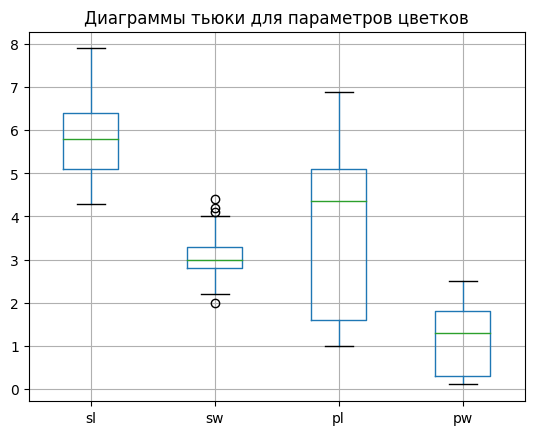


При рассмотрении диаграммы Тьюки для входных параметров, видно, что для параметра *sw* имеем большое количество выбросов и длинные усы. При построении линейной регрессии по этому параметру, мы получили очень плохую модель, имеющую детерминацию $R^2 = 0.182$. Можно предположить, что большое количество выбросов плохо влияет на получаемую модель линейной регрессии. 

## 5. Провести предсказание зависимой переменной по вычисленному уравнению множественной регрессии (Predict Dependent Variable), оценить точность. Для этого делим выборку на тестовую и обучающую. После чего рассчитываем СКО, коэффициент детерминации и строим график ошибок.

MAE: 0.034, R_squared=0.931


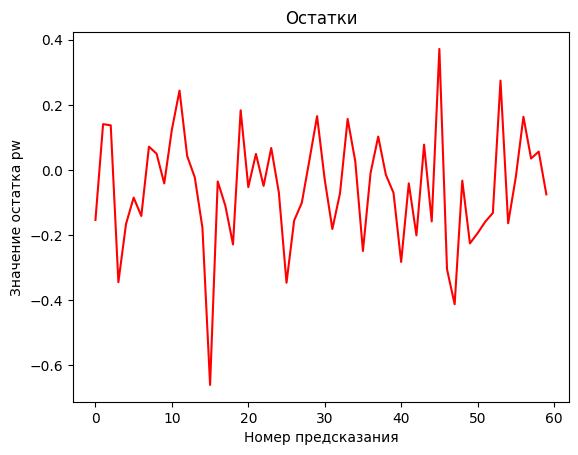

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(iris_pd, test_size=0.4)

column_train = ['sl', 'sw', 'pl', 'pw']
column_train.remove(pred_column)
k_reg = len(column_train)
test_y = test[pred_column].values.reshape(-1, 1)
train_y = train[pred_column].values.reshape(-1, 1)
train_x = train[column_train].values.reshape(-1, k_reg)
test_x = test[column_train].values.reshape(-1, k_reg)

regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

test_pred = regr.predict(test_x)
test_residues = (test_y - test_pred).reshape(-1)
test_MAE = (test_residues **  2).mean()
test_Q = test_y.var()*len(test_y)
test_Qres = np.dot(test_residues, test_residues)
test_R_squared = 1 - (test_Qres/(n-k))/ (test_Q/(n-1))

print(f'MAE: {test_MAE:.3f}, R_squared={test_R_squared:.3f}')

plt.title(f'Остатки')
plt.plot(test_residues, 'r')
plt.xlabel('Номер предсказания')
plt.ylabel(f'Значение остатка {pred_column}')
plt.show()

На этот раз модель оценивалась по её качеству предсказания на выборке, которая не участвовала в обучении. Судя по коэффициенту детерминации модель получилась весьма хорошей. Учитывая то, что в этот раз модель обучалась на меньшей части данных, её коэффициент детерминации практически не изменился и остался больше 0.9. 

## 6.	Сформулировать предложения по улучшению регрессионной модели.

Для улучшения модели можно сделать следующие вещи:
- Провести анализ выбросов параметра *sw*. Модель парной регрессии построенная по нему получилась плохой, возможно он оказывает не лучшее влияние на множественную регрессию;
- Можно попробовать увеличить обучающую выборку.